## Better Way Reform Plan

In [1]:
import sys
sys.path.append("../../")
from taxcalc import *
import pandas as pd
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.transforms import BlendedGenericTransform
%matplotlib inline

### Baseline

In [2]:
policy_xx = Policy()
behavior_xx = Behavior()
records_xx = Records("../../puf.csv")

### The full reform plan

In [3]:
# Set 10% and 15% brackets to 12%
# Set 25% and 28% brackets to 25%
# Set 33%, 35% and 39.6% brackets to 33%
# Repeal Alternative minumum tax
# Standard deduction 12K for single/separate, 24K for married, 18K for single with child(Head of HH)
# Eliminated the additional standard deduction for the aged and blind?
# Personal exemption '_II_credit' set to zero
# Child tax credit phaseout for married couples increased to $150K, increased for married separate to $75K
# Eliminated all itemized deductions except mortgage and charity
# Excluded half of interest income from final taxable interest income to match rates on cap gains/dividends
# Cap gains & dividend income changed
#    Second cap gains threshold moved to same as fourth income tax bracket
#    Rates adjusted to 6%, 12.5% and 16.5%
# Eliminated NIIT
# Implemented business pass-thru rate to 25% by setting top rate to 31% instead of 33%
    # Also adjusted interest income exclusion to maintain 16.5% rate for this group
# New child tax credit and non-child dependent credit implemented oddly (but effectively)
    # The law calls for a $1500 CTC, of which $1000 is refundable as under current law, and a separate credit 
        # for non-child dependents. I dealt with this by leaving the CTC amount unchanged, and using the previously unused 
        # personal cred (II_credit). I changed the formula give filers a non-refundable credit of $500 per dependent, 
        # with the same phaseout as the CTC

# Didn't implement change from depreciation to expensing
# Didn't deal with eliminating net interest expense deductions for businesses
# Didn't eliminate Section 199
# Didn't implement changes to net operating losses
# Didn't repeal estate and gift taxes
# Didn't reduce corporate income tax rate to 20%



policy_y1 = Policy()
behavior_y1 = Behavior()
records_y1 = Records("../../puf.csv")
reform_y1 = {
    2017: {
        '_II_rt1': [0.12],
        '_II_rt2': [0.12],
        '_II_rt3': [0.25],
        '_II_rt4': [0.25],
        '_II_rt5': [0.31],
        '_II_rt6': [0.31],
        '_II_rt7': [0.31],
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_STD': [[12000, 24000, 12000, 18000, 24000, 12000, 1050]],
        '_STD_Aged': [[0,0,0,0,0,0],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0]],
        '_II_em': [0,0,0,0],
        '_CTC_ps': [[75000, 150000, 75000, 75000, 75000, 75000]],
        '_II_credit': [[500, 500, 500, 500, 500, 500]],
        '_II_credit_ps': [[75000, 150000, 75000, 75000, 75000, 75000]],
        '_II_credit_prt': [0.05],
        '_ID_StateLocalTax_HC': [1.0],
        '_ID_Medical_HC': [1.0],
        '_ID_Casualty_HC': [1.0],
        '_ID_Miscellaneous_HC': [1.0],
        '_ID_RealEstate_HC': [1.0],
        '_ALD_Interest_ec': [0.4677],        
        '_CG_thd2': [[183250, 223050, 111525, 203150, 223050, 111525],
                     [186350, 226850, 113425, 206600, 226850, 113425],
                     [189300, 230450, 115225, 209850, 230450, 115225],
                     [190150, 231450, 115725, 210800, 231450, 115725]],
        '_CG_rt1': [0.06],
        '_CG_rt2': [0.125],
        '_CG_rt3': [0.165],
        '_NIIT_trt': [0.0]
    }
}

policy_y1.implement_reform(reform_y1)

behavior_traits = {2017: {'_BE_inc': [0.0], '_BE_sub': [0.3], '_BE_cg': [-3.487]}}
#For substitution effect, Saez, Slemrod and Giertz put it between 0.12 and 0.4

In [4]:
CBO_growth = {2013: {'_factor_target': [0.022, 
                                        0.024,
                                        0.024,
                                        0.025,
                                        0.026,
                                        0.023,
                                        0.018,
                                        0.019,
                                        0.021,
                                        0.021,
                                        0.021,
                                        0.02,
                                        0.02,
                                        0.02]
                     }
              }

# Static calculators

In [5]:
calc_xx = Calculator(policy_xx, records_xx, behavior_xx)
calc_xx.growth.update_economic_growth(CBO_growth)
for i in range(4):
    calc_xx.increment_year()
assert calc_xx.current_year == 2017
calc_y1 = Calculator(policy_y1, records_y1, behavior_y1)
calc_y1.growth.update_economic_growth(CBO_growth)
for i in range(4):
    calc_y1.increment_year()
assert calc_y1.current_year == 2017

You loaded data for 2009.
Your data have been extrapolated to 2013.
You loaded data for 2009.
Your data have been extrapolated to 2013.


In [6]:
calc_xx.calc_all()
calc_y1.calc_all()

### Static revenue effect for 2017

In [7]:
calc_xx_combined = (calc_xx.records._combined * calc_xx.records.s006)
calc_y1_combined = (calc_y1.records._combined * calc_y1.records.s006)

diff_static_y1_xx = (calc_y1_combined - calc_xx_combined).sum() / 10**9
print "Static net revenue change: " + str(diff_static_y1_xx) + " billion dollars"

Static net revenue change: -84.1927291503 billion dollars


### Calculators that iterate across years

In [ ]:
def static_path_change(calcx, calcy):
    static_path = [0] * 10
    calc1 = copy.deepcopy(calcx)
    calc2 = copy.deepcopy(calcy)
    for i in range(10):
        calc1.calc_all()
        calc2.calc_all()
        calc1_combined = (calc1.records._combined * calc1.records.s006)
        calc2_combined = (calc2.records._combined * calc2.records.s006)
        static_path[i] = (calc2_combined - calc1_combined).sum() / 10**9
        if calc1.current_year < 2026:
            calc1.increment_year()
            calc2.increment_year()
    return static_path


In [ ]:
def behavioral_path_change(calcx, calcy):
    behavioral_path = [0] * 10
    calc1 = copy.deepcopy(calcx)
    calc2 = copy.deepcopy(calcy)
    for i in range(10):
        calc1_combined = (calc1.records._combined * calc1.records.s006)
        calc2_combined = (calc2.records._combined * calc2.records.s006)
        behavioral_path[i] = (calc2_combined - calc1_combined).sum() / 10**9
        if calc1.current_year < 2026:
            calc1.increment_year()
            calc2.increment_year()
            calc1.calc_all()
            calc2.behavior.response(calc1, calc2)
        print calc2.current_year
    return behavioral_path

In [ ]:
path_y1_xx = static_path_change(calc_xx, calc_y1)
for i in range(10): 
    print path_y1_xx[i]
print "Total: " + str(sum(path_y1_xx))

## Behavioral calculators

In [8]:
# Behavioral factors
calc_xx.behavior.update_behavior(behavior_traits)
calc_y1.behavior.update_behavior(behavior_traits)

calc_y1_beh = Behavior.response(calc_xx, calc_y1)
print "Done"



Done


### Revenue effect with behavioral changes for 2017

In [9]:
calc_y1_beh_combined = (calc_y1_beh.records._combined * calc_y1_beh.records.s006)
diff_Beh_y1_xx = (calc_y1_beh_combined - calc_xx_combined).sum() / 10**9
print "With behavioral effects, net revenue change: " + str(diff_Beh_y1_xx) + " billion dollars"

With behavioral effects, net revenue change: -26.807361892 billion dollars


In [ ]:
path_y1_beh_xx = behavioral_path_change(calc_xx, calc_y1_beh)
for i in range(10):
    print path_y1_beh_xx[i]
print "Total: " + str(sum(path_y1_beh_xx))

In [10]:
# CTC and dep credit crap
ctc_cost_xx = ((calc_xx.records.c07220 + calc_xx.records.c11070) * calc_xx.records.s006).sum()
ctc_cost_y1 = ((calc_y1_beh.records.c07220 + calc_y1_beh.records.c11070) * calc_y1_beh.records.s006).sum()
bracket_cost = ctc_cost_y1 - ctc_cost_xx #cost of raising phaseout to eliminate marriage penalty
print bracket_cost / 10**9
dep_cost = (calc_y1_beh.records.personal_credit * calc_y1_beh.records.s006).sum()
print dep_cost / 10**9
print ctc_cost_xx / 10**9
print ctc_cost_y1 / 10**9
#Will probably delete this cell. Just here now for diagnosis purposes

5.59321771638
17.4431121802
50.8495244278
56.4427421441


## Diagnostics and analysis of reform plan

In [ ]:
def taxableGain(calc):
    tg = np.maximum(0., np.minimum(calc.records.c23650, calc.records.p23250)) + calc.records.e01100
    return tg

def num_ided(calc):
    ided = calc.records.s006[(calc.records.c04470 > 0.) * (calc.records.c00100 > 0.)].sum()
    return ided
def num_std(calc):
    std = calc.records.s006[(calc.records._standard > 0.) * (calc.records.c00100 > 0.)].sum()
    return std
def wavgMTR_wages(calc):
    mtr = ((calc.mtr('e00200p')[2] * calc.records.e00200 * calc.records.s006).sum() / 
                   (calc.records.e00200 * calc.records.s006).sum())
    return mtr
def wavgMTR_cg(calc):
    gain = taxableGain(calc)
    mtr = ((calc.mtr('p23250')[2] * gain * calc.records.s006).sum() / 
                 (gain * calc.records.s006).sum())
    return mtr
def wavgMTR_int(calc):
    mtr = ((calc.mtr('e00300')[2] * calc.records.c00300 * calc.records.s006).sum() / 
                   (calc.records.c00300 * calc.records.s006).sum())
    return mtr
def wavgMTR_div(calc):
    mtr = ((calc.mtr('e00650')[2] * calc.records.c00650 * calc.records.s006).sum() / 
                   (calc.records.c00650 * calc.records.s006).sum())
    return mtr
def no_inc_tax(calc):
    count = calc.records.s006[calc.records._iitax < 0.0001].sum()
    return count

def lwrMTR_wages(calc1, calc2):
    #calc1 is baseline, calc2 is reform
    diff = calc2.records.s006[(calc2.mtr('e00200p')[2] < calc1.mtr('e00200p')[2])].sum()
    return diff
def lwrMTR_cg(calc1, calc2):
    #calc1 is baseline, calc2 is reform
    diff = calc2.records.s006[(calc2.mtr('p23250')[2] < calc1.mtr('p23250')[2])].sum()
    return diff
def hgrMTR_wages(calc1, calc2):
    #calc1 is baseline, calc2 is reform
    diff = calc2.records.s006[(calc2.mtr('e00200p')[2] > calc1.mtr('e00200p')[2])].sum()
    return diff
def hgrMTR_cg(calc1, calc2):
    #calc1 is baseline, calc2 is reform
    diff = calc2.records.s006[(calc2.mtr('p23250')[2] > calc1.mtr('p23250')[2])].sum()
    return diff
def num_taxcut(calc1, calc2):
    #calc1 is baseline, calc2 is reform
    diff = calc2.records.s006[calc1.records._combined > calc2.records._combined + 0.0001].sum()
    return diff

def diagnose1(calc):
    print str(round(num_ided(calc) / 1000) / 1000.0) + " million taxpayers using itemized deductions"
    print str(round(num_std(calc) / 1000) / 1000.0) + " million taxpayers using the standard deduction"
    print "Average MTR on wage income: " + str(round(wavgMTR_wages(calc) * 10000) / 10000.0)
    print "Average MTR on long-term gains: " + str(round(wavgMTR_cg(calc) * 10000) / 10000.0)
    print "Average MTR on interest: " + str(round(wavgMTR_int(calc) * 10000) / 10000.0)
    print "Average MTR on qualified dividends: " + str(round(wavgMTR_div(calc) * 10000) / 10000.0)
    print "Number paying no income tax: " + str(round(no_inc_tax(calc) / 1000) / 1000.0) + " million"
    
def diagnose2(calc1, calc2):
    #calc1 is baseline, calc2 is reform
    print "Number with lower EMTR on wages: " + str(round(lwrMTR_wages(calc1, calc2) / 1000) / 1000.0) + " million"
    print "Number with higher EMTR on wages: " + str(round(hgrMTR_wages(calc1, calc2) / 1000) / 1000.0) + " million"
    print "Number with lower EMTR on gains: " + str(round(lwrMTR_cg(calc1, calc2) / 1000) / 1000.0) + " million"
    print "Number with higher EMTR on gains: " + str(round(hgrMTR_cg(calc1, calc2) / 1000) / 1000.0) + " million"
    print "Number receiving a tax cut: " + str(round(num_taxcut(calc1, calc2) / 1000) / 1000.0) + " million"


In [ ]:
print "Baseline"
diagnose1(calc_xx)
print "\n Static reform"
diagnose1(calc_y1)
print "\n Comparison"
diagnose2(calc_xx, calc_y1)

In [ ]:
print "Baseline"
diagnose1(calc_xx)
print "\n Dynamic reform"
diagnose1(calc_y1_beh)
print "\n Comparison"
diagnose2(calc_xx, calc_y1_beh)

# Individual Reforms

In [ ]:
# Must do reform plus AMT repeal and compare aginst just AMT repeal

# AMT repeal
policy_amt = Policy()
behavior_amt = Behavior()
records_amt = Records("../../puf.csv")
reform_amt = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0]
    }
}
policy_amt.implement_reform(reform_amt)

# Change in income tax rates
policy_IncTax = Policy()
behavior_IncTax = Behavior()
records_IncTax = Records("../../puf.csv")
reform_IncTax = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_II_rt1': [0.12],
        '_II_rt2': [0.12],
        '_II_rt3': [0.25],
        '_II_rt4': [0.25],
        '_II_rt5': [0.33],
        '_II_rt6': [0.33],
        '_II_rt7': [0.33]
    }
}
policy_IncTax.implement_reform(reform_IncTax)

# Deduction reforms, child tax credit and credit for non-child dependents
policy_ded = Policy()
behavior_ded = Behavior()
records_ded = Records("../../puf.csv")
reform_ded = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_STD': [[12000, 24000, 12000, 18000, 24000, 12000, 1050]],
        '_STD_Aged': [[0,0,0,0,0,0],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0],
                      [0,0,0,0,0,0]],
        '_II_em': [0,0,0,0],
        '_CTC_ps': [[75000, 150000, 75000, 75000, 75000, 75000]],
        '_II_credit': [[500, 500, 500, 500, 500, 500]],
        '_II_credit_ps': [[75000, 150000, 75000, 75000, 75000, 75000]],
        '_II_credit_prt': [0.05],
        '_ID_StateLocalTax_HC': [1.0],
        '_ID_Medical_HC': [1.0],
        '_ID_Casualty_HC': [1.0],
        '_ID_Miscellaneous_HC': [1.0],
        '_ID_RealEstate_HC': [1.0]
    }
}
policy_ded.implement_reform(reform_ded)

# Investment income (interest, cap gains and dividends) reforms
policy_InvTax = Policy()
behavior_InvTax = Behavior()
records_InvTax = Records("../../puf.csv")
reform_InvTax = {
    2017: {
        '_AMT_trt1': [0.0],
        '_AMT_trt2': [0.0],
        '_ALD_Interest_ec': [0.526], #not really accurate yet. have to weight by current rates to get right exclusion
        '_CG_thd2': [[183250, 223050, 111525, 203150, 223050, 111525],
                     [186350, 226850, 113425, 206600, 226850, 113425],
                     [189300, 230450, 115225, 209850, 230450, 115225],
                     [190150, 231450, 115725, 210800, 231450, 115725]],
        '_CG_rt1': [0.06],
        '_CG_rt2': [0.125],
        '_CG_rt3': [0.165],
        '_NIIT_trt': [0.0]
    }
}
policy_InvTax.implement_reform(reform_InvTax)

## Static calculators

In [ ]:
calc_amt = Calculator(policy_amt, records_amt, behavior_amt)
calc_amt.growth.update_economic_growth(CBO_growth)
for i in range(4):
   calc_amt.increment_year()
assert calc_amt.current_year == 2017

calc_IncTax = Calculator(policy_IncTax, records_IncTax, behavior_IncTax)
calc_IncTax.growth.update_economic_growth(CBO_growth)
for i in range(4):
    calc_IncTax.increment_year()
assert calc_IncTax.current_year == 2017

calc_ded = Calculator(policy_ded, records_ded, behavior_ded)
calc_ded.growth.update_economic_growth(CBO_growth)
for i in range(4):
    calc_ded.increment_year()
assert calc_ded.current_year == 2017

calc_InvTax = Calculator(policy_InvTax, records_InvTax, behavior_InvTax)
calc_InvTax.growth.update_economic_growth(CBO_growth)
for i in range(4):
    calc_InvTax.increment_year()
assert calc_InvTax.current_year == 2017


In [ ]:
calc_amt.calc_all()
calc_IncTax.calc_all()
calc_ded.calc_all()
calc_InvTax.calc_all()

In [ ]:
calc_amt_combined = (calc_amt.records._combined * calc_amt.records.s006)
calc_IncTax_combined = (calc_IncTax.records._combined * calc_IncTax.records.s006)
calc_ded_combined = (calc_ded.records._combined * calc_ded.records.s006)
calc_InvTax_combined = (calc_InvTax.records._combined * calc_InvTax.records.s006)

diff_static_amt_xx = (calc_amt_combined - calc_xx_combined).sum() / 10**9
diff_static_IncTax_amt = (calc_IncTax_combined - calc_amt_combined).sum() / 10**9
diff_static_ded_amt = (calc_ded_combined - calc_amt_combined).sum() / 10**9
diff_static_InvTax_amt = (calc_InvTax_combined - calc_amt_combined).sum() / 10**9


### Static revenue effects of individual reforms

In [ ]:
print "Static net revenue change with AMT repeal: " + str(diff_static_amt_xx) + " billion dollars"
print "Static net revenue change with income tax reform: " + str(diff_static_IncTax_amt) + " billion dollars"
print "Static net revenue change with deduction reform: " + str(diff_static_ded_amt) + " billion dollars"
print "Static net revenue change with investment tax reform: " + str(diff_static_InvTax_amt) + " billion dollars"

## Behavioral calculators

In [ ]:
calc_amt.behavior.update_behavior(behavior_traits)
calc_amt_beh = Behavior.response(calc_xx, calc_amt)
print "Done"

In [ ]:
calc_IncTax.behavior.update_behavior(behavior_traits)
calc_IncTax_beh = Behavior.response(calc_amt, calc_IncTax)
print "Done"

In [ ]:
calc_ded.behavior.update_behavior(behavior_traits)
calc_ded_beh = Behavior.response(calc_amt, calc_ded)
print "Done"

In [ ]:
calc_InvTax.behavior.update_behavior(behavior_traits)
calc_InvTax_beh = Behavior.response(calc_amt, calc_InvTax)
print "Done"

### Revenue effects with behavioral changes for 2017

In [ ]:
calc_amt_beh_combined = (calc_amt_beh.records._combined * calc_amt_beh.records.s006)
calc_IncTax_beh_combined = (calc_IncTax_beh.records._combined * calc_IncTax_beh.records.s006)
calc_ded_beh_combined = (calc_ded_beh.records._combined * calc_ded_beh.records.s006)
calc_InvTax_beh_combined = (calc_InvTax_beh.records._combined * calc_InvTax_beh.records.s006)

diff_Beh_amt_xx = (calc_amt_beh_combined - calc_xx_combined).sum() / 10**9
diff_Beh_IncTax_amt = (calc_IncTax_beh_combined - calc_amt_beh_combined).sum() / 10**9
diff_Beh_ded_amt = (calc_ded_beh_combined - calc_amt_beh_combined).sum() / 10**9
diff_Beh_InvTax_amt = (calc_InvTax_beh_combined - calc_amt_beh_combined).sum() / 10**9

print "With behavioral effects, net revenue change from AMT repeal: " + str(diff_Beh_amt_xx) + " billion dollars"
print "With behavioral effects, net revenue change from income tax rate reform: " + str(diff_Beh_IncTax_amt) + " billion dollars"
print "With behavioral effects, net revenue change from deduction reform: " + str(diff_Beh_ded_amt) + " billion dollars"
print "With behavioral effects, net revenue change from investment tax reform: " + str(diff_Beh_InvTax_amt) + " billion dollars"

### Static iterator

In [ ]:
static_path_amt_xx = static_path_change(calc_xx, calc_amt)
for i in static_path_amt_xx:
    print i

In [ ]:
static_path_IncTax_amt = static_path_change(calc_amt, calc_IncTax)
for i in static_path_IncTax_amt:
    print i

In [ ]:
static_path_ded_amt = static_path_change(calc_amt, calc_ded)
for i in static_path_ded_amt:
    print i

In [ ]:
static_path_InvTax_amt = static_path_change(calc_amt, calc_InvTax)
for i in static_path_InvTax_amt:
    print i

### Behavioral iterator

In [ ]:
beh_path_amt_xx = behavioral_path_change(calc_xx, calc_amt_beh)
for i in beh_path_amt_xx:
    print i

In [ ]:
beh_path_IncTax_amt = behavioral_path_change(calc_amt_beh, calc_IncTax_beh)
for i in beh_path_IncTax_amt:
    print i

In [ ]:
beh_path_ded_amt = behavioral_path_change(calc_amt_beh, calc_ded_beh)
for i in beh_path_ded_amt:
    print i

In [ ]:
beh_path_InvTax_amt = behavioral_path_change(calc_amt_beh, calc_InvTax_beh)
for i in beh_path_InvTax_amt:
    print i

# MTR charts

### These are rate graphers. They can either plot by AGI quantiles or by AGI increments.

In [10]:
def getMTR(calc1):
    return np.asarray(calc1.mtr('e00200p')[1])

def getMTR_cg(calc1):
    return np.asarray(calc1.mtr('p23250')[1])

def getAGI(calc1):
    return np.asarray(np.where(calc1.records.c00100 < 0, 0., calc1.records.c00100))

def getAvgRate(calc1):
    agi1 = getAGI(calc1) + 0.001
    avgRate1 = np.asarray(calc1.records._combined) / np.asarray((getAGI(calc1)))
    avgRate2 = np.where(avgRate1 > 1, 1.0, avgRate1)
    avgRate3 = np.where(avgRate2 < 0, 0., avgRate2)
    return avgRate3

def itemizers(calc1):
    ided = np.where(calc1.records.c04470 > calc1.records._standard, 1, 0)
    return ided

def group_evenly(calc1):
    mtr = getMTR(calc1)
    mtrCG = getMTR_cg(calc1)
    agi = getAGI(calc1)
    avgRate = getAvgRate(calc1)
    ided = itemizers(calc1)
    wgt = np.asarray(copy.deepcopy(calc1.records.s006))
    
    all_together = zip(agi, mtr, mtrCG, avgRate, ided, wgt)
    all_together.sort()
    all_apart = zip(*all_together)
    agi_sorted = np.asarray(all_apart[0])
    mtr_sorted = np.asarray(all_apart[1])
    mtrCG_sorted = np.asarray(all_apart[2])
    avgRate_sorted = np.asarray(all_apart[3])
    ided_sorted = np.asarray(all_apart[4])
    wgt_sorted = np.asarray(all_apart[5])
    
    mtrList = [0] * 98
    mtrCGList = [0] * 98
    agiList = [0] * 98
    avgRateList = [0] * 98
    idedList = [0] * 98
    wgtList = [0] * 98
    
    for i in range(98):
        agiList[i] = (agi_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        mtrList[i] = (mtr_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        mtrCGList[i] = (mtrCG_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        avgRateList[i] = (avgRate_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        idedList[i] = (ided_sorted[(i*2243):((i+1)*2243)] * wgt_sorted[(i*2243):((i+1)*2243)]).sum()
        wgtList[i] =  wgt_sorted[(i*2243):((i+1)*2243)].sum()
    
    
    agiFinal = np.asarray(agiList) / np.asarray(wgtList)
    mtrFinal = np.asarray(mtrList) / np.asarray(wgtList)
    mtrCGFinal = np.asarray(mtrCGList) / np.asarray(wgtList)
    avgRateFinal = np.asarray(avgRateList) / np.asarray(wgtList)
    idedFinal = np.asarray(idedList) / np.asarray(wgtList)
    return agiFinal, mtrFinal, mtrCGFinal, avgRateFinal, idedFinal

def plot_evenly(calc_baseline, calc_reform, Type):
    assert Type in ('mtr', 'mtrcg', 'avgrate', 'ided')
    baseline = group_evenly(calc_baseline)
    reform = group_evenly(calc_reform)
    
    ydata_baseline = []
    ydata_reform = []
    title = ""
    ylab = ""
    if Type == 'mtr':
        title = 'Marginal tax rate on wages'
        ydata_baseline = baseline[1]
        ydata_reform = reform[1]
        ylabel = 'MTR'
    elif Type == 'mtrcg':
        title = 'Marginal tax rate on capital gains'
        ydata_baseline = baseline[2]
        ydata_reform = reform[2]
        ylabel = 'MTR'
    elif Type == 'avgrate':
        title = "Average tax rate"
        ydata_baseline = baseline[3]
        ydata_reform = reform[3]
        ylabel = 'Average rate'
    else: 
        title = 'Probability of itemizing'
        ylabel = 'Fraction itemizing'
        ydata_baseline = baseline[4]
        ydata_reform = reform[4]
    
    plt.plot(ydata_baseline)
    plt.plot(ydata_reform)
    #plt.plot(ydata_baseline[25:76])
    #plt.plot(ydata_reform[25:76])
    plt.legend(['Baseline', 'Reform'], loc='lower right')
    plt.title(title)
    plt.xlabel('AGI quantile')
    plt.ylabel(ylabel)

def group_by_increments(calc1, bins, maxagi):
    mtr = getMTR(calc1)
    mtrCG = getMTR_cg(calc1)
    agi = getAGI(calc1)
    avgRate = getAvgRate(calc1)
    ided = itemizers(calc1)
    wgt = np.asarray(copy.deepcopy(calc1.records.s006))
    incr = int(maxagi / bins)
    
    mtrList = [0] * bins
    mtrCGList = [0] * bins
    agiList = range(incr / 2, maxagi + incr / 2, incr)
    avgRateList = [0] * bins
    idedList = [0] * bins
    wgtList = [0] * bins
    
    for i in range(bins):
        mtrList[i] = np.asarray([(mtr[j]*wgt[j]) for j in range(219814) if int(agi[j] / incr)==i]).sum()
        mtrCGList[i] = np.asarray([(mtrCG[j]*wgt[j]) for j in range(219814) if int(agi[j] / incr)==i]).sum()
        avgRateList[i] = np.asarray([(avgRate[j]*wgt[j]) for j in range(219814) if int(agi[j] / incr)==i]).sum()
        idedList[i] = np.asarray([(ided[j]*wgt[j]) for j in range(219814) if int(agi[j] / incr)==i]).sum()
        wgtList[i] = np.asarray([wgt[j] for j in range(219814) if int(agi[j] / incr)==i]).sum()
    mtrFinal = np.asarray(mtrList) / np.asarray(wgtList)
    mtrCGFinal = np.asarray(mtrCGList) / np.asarray(wgtList)
    avgRateFinal = np.asarray(avgRateList) / np.asarray(wgtList)
    idedFinal = np.asarray(idedList) / np.asarray(wgtList)
    return agiList, mtrFinal, mtrCGFinal, avgRateFinal, idedFinal

def plot_by_increments(calc_baseline, calc_reform, Type, bins, maxagi):
    assert Type in ('mtr', 'mtrcg', 'avgrate', 'ided')
    baseline = group_by_increments(calc_baseline, bins, maxagi)
    reform = group_by_increments(calc_reform, bins, maxagi)
    
    xdata = baseline[0]
    ydata_baseline = []
    ydata_reform = []
    title = ""
    ylab = ""
    if Type == 'mtr':
        title = 'Marginal tax rate on wages'
        ydata_baseline = baseline[1]
        ydata_reform = reform[1]
        ylabel = 'MTR'
    elif Type == 'mtrcg':
        title = 'Marginal tax rate on capital gains'
        ydata_baseline = baseline[2]
        ydata_reform = reform[2]
        ylabel = 'MTR'
    elif Type == 'avgrate':
        title = "Average tax rate"
        ydata_baseline = baseline[3]
        ydata_reform = reform[3]
        ylabel = 'Average rate'
    else: 
        title = 'Probability of itemizing'
        ylabel = 'Fraction itemizing'
        ydata_baseline = baseline[4]
        ydata_reform = reform[4]
    
    plt.plot(xdata, ydata_baseline)
    plt.plot(xdata, ydata_reform)
    plt.legend(['Baseline', 'Reform'], loc='lower right')
    plt.title(title)
    plt.xlabel('AGI')
    plt.ylabel(ylabel)
    
    

### Graphs of rates by AGI quantiles

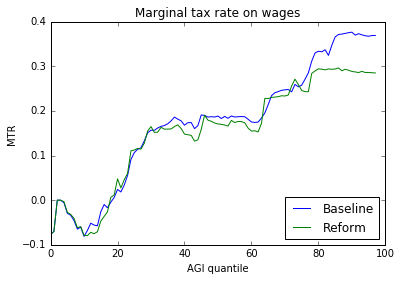

In [34]:
plot_evenly(calc_xx, calc_y1_beh, 'mtr')

In [ ]:
plot_evenly(calc_xx, calc_y1_beh, 'mtrcg')

In [ ]:
plot_evenly(calc_xx, calc_y1_beh, 'avgrate')

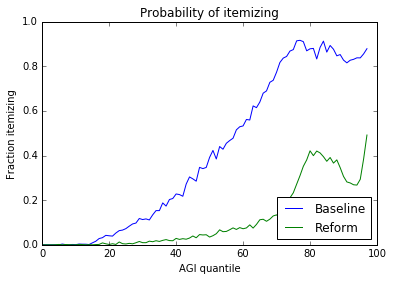

In [35]:
plot_evenly(calc_xx, calc_y1_beh, 'ided')

In [ ]:
mtr_diff = group_evenly(calc_y1_beh)[1] - group_evenly(calc_xx)[1]
plt.plot(mtr_diff)
plt.title('Change in wage EMTR')
plt.xlabel('AGI quantile')

In [ ]:
avgRate_diff = group_evenly(calc_y1_beh)[3] - group_evenly(calc_xx)[3]
plt.plot(avgRate_diff)
plt.title('Change in average tax rate')
plt.xlabel('AGI quantile')

### Graphs of rates by AGI increments

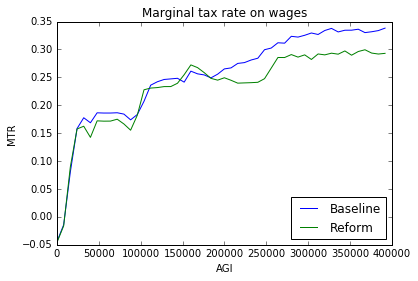

In [36]:
plot_by_increments(calc_xx, calc_y1_beh, 'mtr', 50, 400000)

In [ ]:
plot_by_increments(calc_xx, calc_y1_beh, 'mtrcg', 50, 400000)

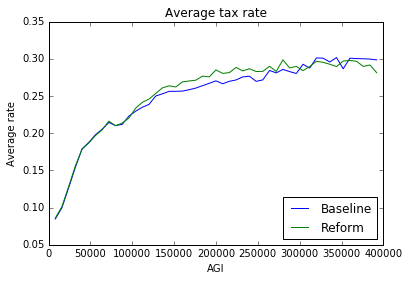

In [25]:
plot_by_increments(calc_xx, calc_y1_beh, 'avgrate', 50, 400000)

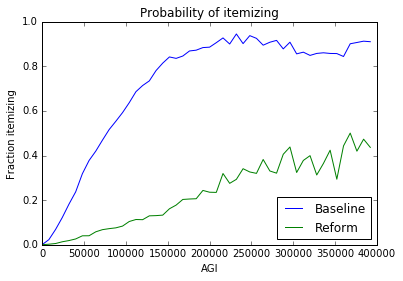

In [37]:
plot_by_increments(calc_xx, calc_y1_beh, 'ided', 50, 400000)

In [ ]:
mtr_diff_incr = group_by_increments(calc_y1_beh, 50, 400000)[1] - group_by_increments(calc_xx, 50, 400000)[1]
plt.plot(range(0, 200000, 4000), mtr_diff_incr)
plt.title('Change in wage EMTR by AGI')
plt.xlabel('AGI')

In [ ]:
avgRate_diff_incr = group_by_increments(calc_y1_beh, 50, 400000)[3] - group_by_increments(calc_xx, 50, 400000)[3]
plt.plot(range(0, 300000, 6000), avgRate_diff_incr)
plt.title('Change in average tax rate by AGI')
plt.xlabel('AGI')

## Plot rate charts for different demographics

### These are rate graphers for different family types. They can either plot by AGI quantiles or by AGI increments.

#### Married with 2 kids (m2k), single with 1 kid (s1k), single with no kids (s0k)

In [46]:
def group_evenly_family(calc, family_type):
    assert family_type in ['m2k', 's1k', 's0k']
    mars = calc.records.MARS
    kids = calc.records.n24
    m2k_ind = [x for x in range(219814) if ((mars[x]==2) and (kids[x]==2))]
    s1k_ind = [x for x in range(219814) if ((mars[x]==4) and (kids[x]==1))][:8400]
    s0k_ind = [x for x in range(219814) if ((mars[x]==1) and (kids[x]==0))][:81472]
    
    if family_type == 'm2k':
        bins = 95
        size = 183
        use_ind = m2k_ind
    elif family_type == 's1k':
        bins = 48
        size = 175
        use_ind = s1k_ind
    else:
        bins = 67
        size = 271
        use_ind = s0k_ind
    
    mtr = getMTR(calc)[use_ind]
    agi = getAGI(calc)[use_ind]
    avg = getAvgRate(calc)[use_ind]
    wgt = np.asarray(copy.deepcopy(calc.records.s006))[use_ind]
    
    all_together = zip(agi, mtr, avg, wgt)
    all_together.sort()
    all_apart = zip(*all_together)
    agi_sorted = np.asarray(all_apart[0])
    mtr_sorted = np.asarray(all_apart[1])
    avg_sorted = np.asarray(all_apart[2])
    wgt_sorted = np.asarray(all_apart[3])
    
    agiList = [0] * bins
    mtrList = [0] * bins
    avgList = [0] * bins
    wgtList = [0] * bins
    
    for i in range(bins):
        agiList[i] = (agi_sorted[(i*size):((i+1)*size)] * wgt_sorted[(i*size):((i+1)*size)]).sum()
        mtrList[i] = (mtr_sorted[(i*size):((i+1)*size)] * wgt_sorted[(i*size):((i+1)*size)]).sum()
        avgList[i] = (avg_sorted[(i*size):((i+1)*size)] * wgt_sorted[(i*size):((i+1)*size)]).sum()
        wgtList[i] =  wgt_sorted[(i*size):((i+1)*size)].sum()
    
    
    agiFinal = np.asarray(agiList) / np.asarray(wgtList)
    mtrFinal = np.asarray(mtrList) / np.asarray(wgtList)
    avgFinal = np.asarray(avgList) / np.asarray(wgtList)
    return agiFinal, mtrFinal, avgFinal
        
def plot_evenly_mtr_family(calc_baseline, calc_reform, family_type, rate_type):
    assert rate_type in ['mtr', 'avgrate']
    base = group_evenly_family(calc_baseline, family_type)
    ref = group_evenly_family(calc_reform, family_type)
    if rate_type == 'mtr':
        baseline == base[1]
        reform = ref[2]
        if family_type == "m2k":
            title = "Wage EMTR, married with 2 kids"
        elif family_type == "s1k":
            title = "Wage EMTR, single with 1 kid"
        else:
            title = "Wage EMTR, single with no kids"
    else:
        baseline = base[2]
        reform = ref[2]
        if family_type == "m2k":
            title = "Average tax rate, married with 2 kids"
        elif family_type == "s1k":
            title = "Average tax rate, single with 1 kid"
        else:
            title = "Average tax rate, single with no kids"
    plt.plot(baseline)
    plt.plot(reform)
    plt.title(title)
    plt.legend(['Baseline', 'Reform'], loc='lower right')
    plt.xlabel('AGI quantile')
    plt.ylabel('MTR')

def group_by_increments_family(calc, family_type, bins, maxagi):
    assert family_type in ['m2k', 's1k', 's0k', 'all']
    mars = calc.records.MARS
    kids = calc.records.n24
    m2k_ind = [x for x in range(219814) if ((mars[x]==2) and (kids[x]==2))]
    s1k_ind = [x for x in range(219814) if ((mars[x]==4) and (kids[x]==1))]
    s0k_ind = [x for x in range(219814) if ((mars[x]==1) and (kids[x]==0))]
    
    mtr = getMTR(calc)
    agi = getAGI(calc)
    avg = getAvgRate(calc)
    ided = itemizers(calc)
    wgt = np.asarray(copy.deepcopy(calc.records.s006))
    
    if family_type == "m2k":
        use_ind = m2k_ind
    elif family_type == "s1k":
        use_ind = s1k_ind
    elif family_type == 's1k':
        use_ind = s0k_ind
    else: 
        use_ind = range(219814)
    num_filers = len(use_ind)
    incr = int(maxagi / bins)
    
    mtrList = [0] * bins
    agiList = range(incr / 2, maxagi + incr / 2, incr)
    avgList = [0] * bins
    idedList = [0] * bins
    wgtList = [0] * bins
    
    for i in range(bins):
        mtrList[i] = np.asarray([(mtr[j]*wgt[j]) for j in use_ind if int(agi[j] / incr)==i]).sum()
        avgList[i] = np.asarray([(avg[j]*wgt[j]) for j in use_ind if int(agi[j] / incr)==i]).sum()
        idedList[i] = np.asarray([(ided[j]*wgt[j]) for j in use_ind if int(agi[j] / incr)==i]).sum()
        wgtList[i] = np.asarray([wgt[j] for j in use_ind if int(agi[j] / incr)==i]).sum()
    mtrFinal = np.asarray(mtrList) / np.asarray(wgtList)
    avgFinal = np.asarray(avgList) / np.asarray(wgtList)
    idedFinal = np.asarray(idedList) / np.asarray(wgtList)
    return agiList, mtrFinal, avgFinal, idedFinal

def plot_by_increments_family(calc_baseline, calc_reform, family_type, rate_type, bins, maxagi):
    assert rate_type in ['mtr', 'avgrate', 'ided', 'all']
    base = group_by_increments_family(calc_baseline, family_type, bins, maxagi)
    ref = group_by_increments_family(calc_reform, family_type, bins, maxagi)
    if family_type == "m2k":
        tit2 = "married with 2 kids"
    elif family_type == "s1k":
        tit2 = "single with 1 kid"
    elif family_type == 's0k': 
        tit2 = "single with no kids"
    else:
        tit2 = "all taxpayers"
    if rate_type == 'mtr':
        baseline = base[1]
        reform = ref[1]
        ylab = 'MTR'
        tit1 = 'Wage EMTR'
    elif rate_type == 'avgrate':
        baseline = base[2]
        reform = ref[2]
        ylab = 'Average tax rate'
        tit1 = 'Average tax rate'
    else:
        baseline = base[3]
        reform = ref[3]
        ylab = 'Fraction itemizing'
        tit1 = 'Probability of itemizing'
    title = tit1 + ', ' + tit2
    
    plt.plot(base[0], baseline)
    plt.plot(ref[0], reform)
    plt.title(title)
    plt.legend(['Baseline', 'Reform'], loc='lower right')
    plt.xlabel('AGI')
    plt.ylabel(ylab)

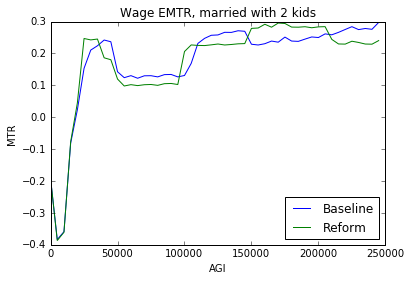

In [41]:
plot_by_increments_family(calc_xx, calc_y1_beh, 'm2k', 'mtr', 50, 250000)

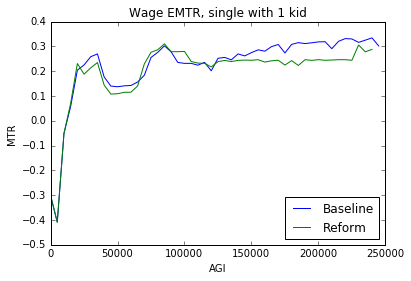

In [20]:
plot_by_increments_family(calc_xx, calc_y1_beh, 's1k', 'mtr', 50, 250000)

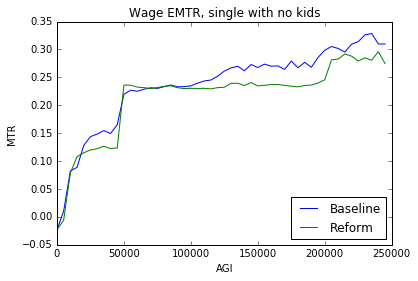

In [21]:
plot_by_increments_family(calc_xx, calc_y1_beh, 's0k', 'mtr', 50, 250000)

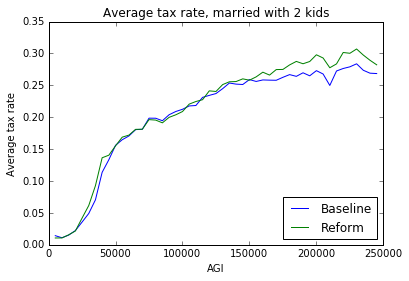

In [27]:
plot_by_increments_family(calc_xx, calc_y1_beh, 'm2k', 'avgrate', 50, 250000)

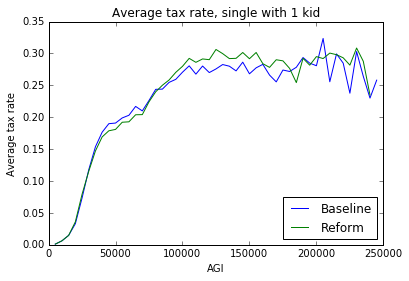

In [28]:
plot_by_increments_family(calc_xx, calc_y1_beh, 's1k', 'avgrate', 50, 250000)

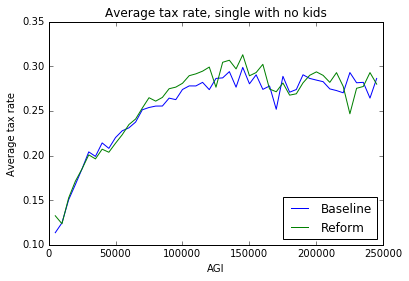

In [29]:
plot_by_increments_family(calc_xx, calc_y1_beh, 's0k', 'avgrate', 50, 250000)

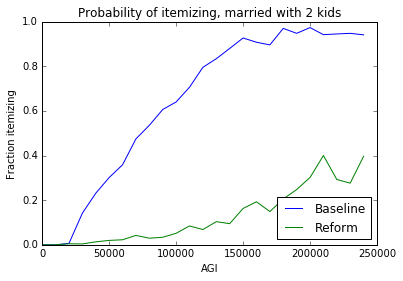

In [45]:
plot_by_increments_family(calc_xx, calc_y1_beh, 'm2k', 'ided', 25, 250000)

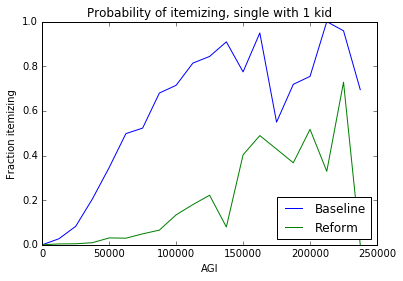

In [47]:
plot_by_increments_family(calc_xx, calc_y1_beh, 's1k', 'ided', 20, 250000)

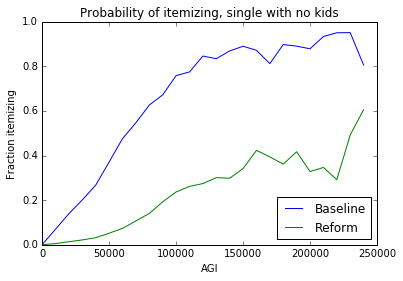

In [48]:
plot_by_increments_family(calc_xx, calc_y1_beh, 's0k', 'ided', 25, 250000)

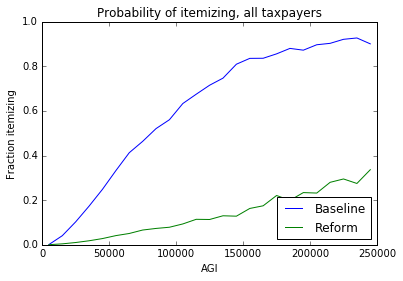

In [47]:
plot_by_increments_family(calc_xx, calc_y1_beh, 'all', 'ided', 25, 250000)

## This section to plot changes in deductions and credits

In [37]:
def compare_deductions(calc_baseline, calc_reform, family_type, bins, maxagi):
    assert family_type in ['m2k', 's1k', 's0k', 'all']
    mars = calc_baseline.records.MARS
    kids = calc_baseline.records.n24
    m2k_ind = [x for x in range(219814) if ((mars[x]==2) and (kids[x]==2))]
    s1k_ind = [x for x in range(219814) if ((mars[x]==4) and (kids[x]==1))]
    s0k_ind = [x for x in range(219814) if ((mars[x]==1) and (kids[x]==0))]
    agi_b = getAGI(calc_baseline)
    ided_b = itemizers(calc_baseline)
    agi_r = getAGI(calc_reform)
    ided_r = itemizers(calc_reform)
    amtIded_b = np.asarray(copy.deepcopy(calc_baseline.records.c04470))
    amtIded_r = np.asarray(copy.deepcopy(calc_reform.records.c04470))
    wgt_b = np.asarray(copy.deepcopy(calc_baseline.records.s006))
    wgt_r = np.asarray(copy.deepcopy(calc_reform.records.s006))
    stded_b = np.asarray(copy.deepcopy(calc_baseline.records._standard))
    stded_r = np.asarray(copy.deepcopy(calc_reform.records._standard))
    totalDed_b = np.maximum(stded_b, amtIded_b) + calc_baseline.records._prexmp
    totalDed_r = np.maximum(stded_r, amtIded_r)
    cred1_b = calc_baseline.records.c07220 + calc_baseline.records.c11070
    cred1_r = calc_reform.records.c07220 + calc_reform.records.c11070
    cred2_b = calc_baseline.records.personal_credit
    cred2_r = calc_reform.records.personal_credit
    totalCred_b = 0 #cred1_b + cred2_b
    totalCred_r = 0 #cred1_r + cred2_r
    total_b = totalDed_b + totalCred_b
    total_r = totalDed_r + totalCred_r
    
    
    if family_type == "m2k":
        use_ind = m2k_ind
        title = "Deductions, married w/ 2 kids"
    elif family_type == "s1k":
        use_ind = s1k_ind
        title = "Deductions, single w/ 1 kid"
    elif family_type == 's0k':
        use_ind = s0k_ind
        title = "Deductions, single w/ no kids"
    else:
        use_ind = range(219814)
        title = "Deductions, all taxpayers"
    num_filers = len(use_ind)
    incr = int(maxagi / bins)
    
    agiList = range(incr / 2, maxagi + incr / 2, incr)
    totalList_b = [0] * bins
    wgtList_b = [0] * bins
    totalList_r = [0] * bins
    wgtList_r = [0] * bins
    
    for i in range(bins):
        totalList_b[i] = np.asarray([(total_b[j]*wgt_b[j]) for j in use_ind if int(agi_b[j] / incr)==i]).sum()
        totalList_r[i] = np.asarray([(total_r[j]*wgt_r[j]) for j in use_ind if int(agi_r[j] / incr)==i]).sum()
        wgtList_b[i] = np.asarray([wgt_b[j] for j in use_ind if int(agi_b[j] / incr)==i]).sum()
        wgtList_r[i] = np.asarray([wgt_r[j] for j in use_ind if int(agi_r[j] / incr)==i]).sum()
        
    totalFinal_b = np.asarray(totalList_b) / np.asarray(wgtList_b) #/ np.asarray(agiList)
    totalFinal_r = np.asarray(totalList_r) / np.asarray(wgtList_r) #/ np.asarray(agiList)
    
    plt.plot(agiList[5:bins], totalFinal_b[5:bins])
    plt.plot(agiList[5:bins], totalFinal_r[5:bins])
    plt.title(title)
    plt.legend(['Baseline', 'Reform'], loc='upper left')
    plt.xlabel('AGI')
    
    

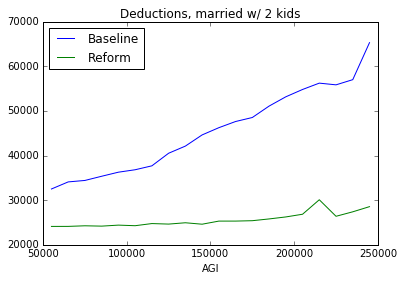

In [38]:
compare_deductions(calc_xx, calc_y1_beh, 'm2k', 25, 250000)

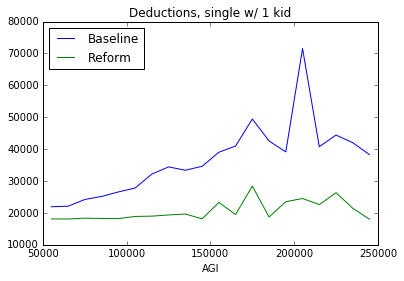

In [39]:
compare_deductions(calc_xx, calc_y1_beh, 's1k', 25, 250000)

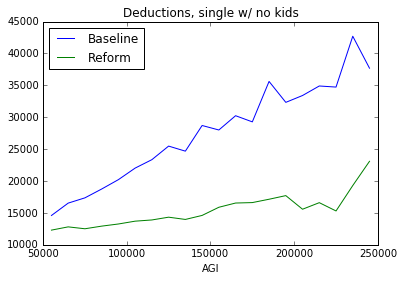

In [40]:
compare_deductions(calc_xx, calc_y1_beh, 's0k', 25, 250000)

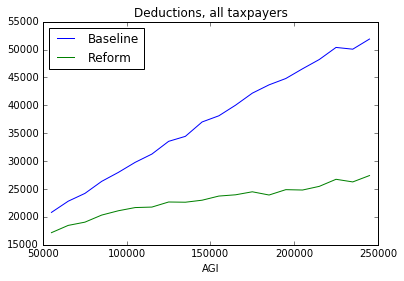

In [41]:
compare_deductions(calc_xx, calc_y1_beh, 'all', 25, 250000)